# Conformation Search: An Application of Monte Carlo Methods
The Monte Carlo method is often used to perform conformation Search. The goal of conformation search is to explore the phase space of the system and try the identify the important, low-energy conformations.

## Probabilities in the Canonical Ensemble
In the canonical ensemble, the probability of occupying a a given point in the phase space is related to its energy by the Boltzmann factor $e^{-E(\textbf{q}, \textbf{p})/k_B T}$, where $(\textbf{q}$ and $\textbf{p}$ are the positions and momenta. Mathematically, the probability is given by

\begin{align}
    P(\textbf{q}, \textbf{p}) = Q^{-1} e^{-E(\textbf{q}, \textbf{p})/k_B T}
\end{align}
where $Q$ is called the partition function and it is given by:
\begin{align}
    Q = \int \int e^{-E(\textbf{q}, \textbf{p})/k_B T} d \textbf{q} d \textbf{p}.
\end{align}

The probability decreases exponentially as the energy increases. The average for a given propetry $A$ is given by:
\begin{align}
    \langle A \rangle = \int \int A(\textbf{q}, \textbf{p}) P(\textbf{q}, \textbf{p}) d \textbf{q} d \textbf{p}.
\end{align}

Because the probability of high-energy configurations is low, these configurations do not contribute appreciably to the properties of the system at equilibrium. Therefore, it is not important to sample and identify high-energy configurations. The Metropolis Monte Carlo procedure is designed to mainly explore low energy configurations while also allowing for overcoming potential energy barriers.

## Part I: Conformation Search for Pentane
We will explore below the conformation of pentane using the MMFF94 force field. We will focus only on the two C-C-C-C dihedral angles because they are the most flexible degrees of freedom. We will perform three kinds of conformation search:
- Systematic
- Random
- Monte Carlo

In the systematic search, we will build a complete picture of the potential energy surface of pentane along the two dihedral degrees of freedom ($\theta_1$ and $\theta_2$). We will construct a 361 by 361 grid of values (130321 values) and calculate the energy at each ($\theta_1$, $\theta_2$) point. Then, we will construct a three-dimensional potential energy surface.

In the random search, we will start with the same initial value of $\theta_1$ and $\theta_2$ and perform a certain number of iterations. At each step, we will increase or decrease the value of a randomly selected dihedral angle by a fixed amount. We will accept all the moves.

In the Monte Carlo search, we will start with some initial value of $\theta_1$ and $\theta_2$. Then, we will perform a certain number of Monte Carlo iterations. At each step, we will increase or decrease the value of a randomly selected dihedral angle by a fixed amount. Then, unlike the random search procedure, we will accept or reject the move based on the Metropolis criteria. We will always accept the move if the energy of the system decreases. If the energy increases, we generate a random number between 0 and 1 and accept the move if $e^{-\Delta E/kT}$ is larger than the random number.

Below we show the geometry of pentane:

In [201]:
# First display the geometry of pentane
import numpy as np
from openbabel import openbabel as ob
import nglview as nv

mol = ob.OBMol()
def to_pdb(infile,outfile):
    conv = ob.OBConversion()
    conv.SetInAndOutFormats("xyz","pdb")
    conv.ReadFile(mol, infile)
    conv.WriteFile(mol, outfile)
to_pdb("pentane.xyz","gg.pdb")
view = nv.show_structure_file("gg.pdb")
view.add_representation('label', labelType='serial', backgroundColor='black', showBackground=True)
view

NGLWidget()

### Systematic Search

Pentane has two flexible degrees of freedom. We expect the *anti* configuration for the two dihedral angles ($\theta_1 = \theta_2 = 180^\circ$) to be the global minimum energy structure. Additionally, we expect that the *syn* configuration where $\theta_1=\theta_2=0$ is a high energy structure because of steric repulsion. We will verify that this is the case by computing the complete potential energy surface using systematic search.

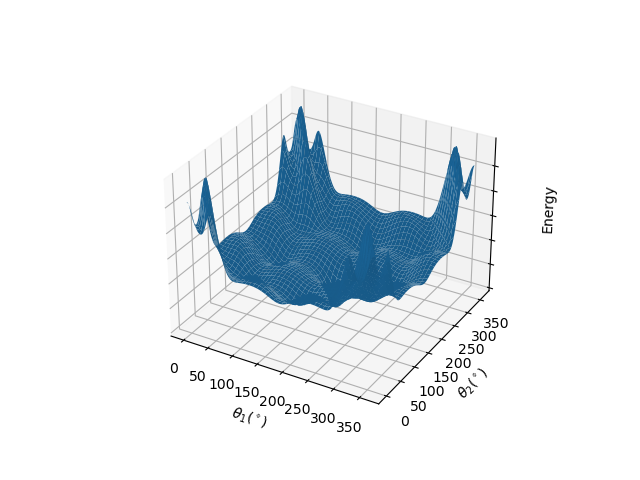

In [179]:
 %matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform the systematic search
torsions = [[1, 2, 3, 4], [2, 3, 4, 5]]

# Generate a mesh of grid points for the two dihedral angles
theta1 = np.linspace(0, 2*np.pi, 361)
theta2 = np.linspace(0, 2*np.pi, 361)

theta1, theta2 = np.meshgrid(theta1, theta2)
energies = np.zeros_like(theta1)

# Calculate the energy on the grid
ff = ob.OBForceField_FindType("MMFF94")
for i in range(len(theta1)):
    for j in range(len(theta2)):
        mol.SetTorsion(torsions[0][0], torsions[0][1], torsions[0][2], torsions[0][3], theta1[i, j])
        mol.SetTorsion(torsions[1][0], torsions[1][1], torsions[1][2], torsions[1][3], theta2[i, j])
        ff.Setup(mol)
        energies[i, j] = ff.Energy()
min_energy = np.min(energies)
energies -= min_energy

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(theta1*180.0/np.pi, theta2*180.0/np.pi, np.log10(energies + 0.1)) # Avoid zero for log scale
ax.set_zticklabels([])
ax.set_xlabel(r'$\theta_1 (^\circ)$')
ax.set_ylabel(r'$\theta_2 (^\circ)$')
ax.set_zlabel('Energy')
plt.show()

The figure above displays the complete potential energy surface. We use a log scale for the z-axis (energy) to show the detailed variations in the energy. Our expectations above are indeed correct. The global minimum energy structure is when both dihedral angles are in the *anti* configuration ($\theta_1 = \theta_2 = 180^\circ$) while the global maximum is the *syn* configuration. In addition, there are some local minima at intermediate dihedral angle values that are relatively high in energy compared to the global minimum. We will visualize below different conformations of pentane.

In [193]:
from IPython.display import display
def to_pdb(infile,outfile):
    conv = ob.OBConversion()
    conv.SetInAndOutFormats("xyz","pdb")
    conv.ReadFile(mol, infile)
    mol.SetTorsion(*torsions[0], np.pi)
    mol.SetTorsion(*torsions[1], np.pi)
    conv.WriteFile(mol, outfile)
to_pdb("pentane.xyz","gg.pdb")
view = nv.show_structure_file("gg.pdb")
print("The global minimum structure: theta1 = theta2 = 180 degrees")
display(view)

# Visualize here three other local minima using values obtained from the above potential energy surface.
ang=[[175,76],[284,185],[82,82]]
for i in range(3):
    def to_pdb(infile,outfile):
        conv = ob.OBConversion()
        conv.SetInAndOutFormats("xyz","pdb")
        conv.ReadFile(mol, infile)
        mol.SetTorsion(*torsions[0], (ang[i][0]/180)*np.pi)
        mol.SetTorsion(*torsions[1], (ang[i][1]/180)*np.pi)
        conv.WriteFile(mol, outfile)
    to_pdb("pentane.xyz","gg.pdb")
    view = nv.show_structure_file("gg.pdb")
    display(view)



The global minimum structure: theta1 = theta2 = 180 degrees


NGLWidget()

NGLWidget()

NGLWidget()

NGLWidget()

In [197]:
# Visualize here the global maximum

def to_pdb(infile,outfile):
    conv = ob.OBConversion()
    conv.SetInAndOutFormats("xyz","pdb")
    conv.ReadFile(mol, infile)
    mol.SetTorsion(*torsions[0], (50/180)*np.pi)
    mol.SetTorsion(*torsions[1], (350/180)*np.pi)
    conv.WriteFile(mol, outfile)
to_pdb("pentane.xyz","gg.pdb")
view = nv.show_structure_file("gg.pdb")
view

NGLWidget()

## Random Search

Now we will explore the potential energy surface using the random search procedure. We will start from some randomly chosen initial structure. Then, at each step, we will select one dihedral angle and either increase it or decrease by $2^\circ$. 

The initial values: theta1 = 197.572861; theta2 = 257.468172 degrees


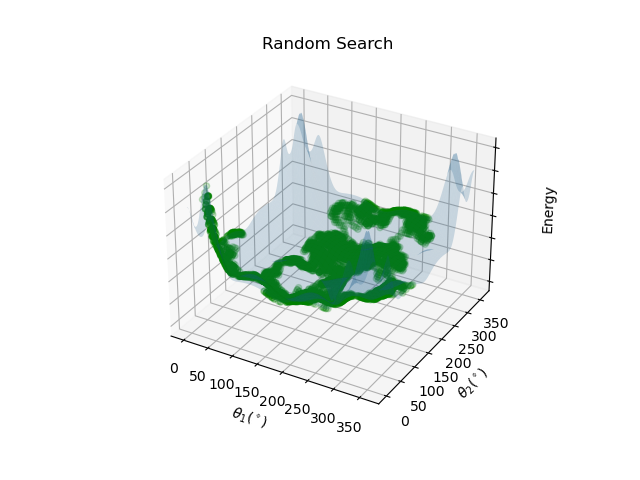

In [199]:
# Set the conformation search parameters
niter = 10000
step = np.pi/180.0*4.0

# set random number seed
np.random.seed(0)

# Set initial torsions to some random values
initial_theta1 = np.random.uniform(0, 2*np.pi)
initial_theta2 = np.random.uniform(0, 2*np.pi)
mol.SetTorsion(torsions[0][0], torsions[0][1], torsions[0][2], torsions[0][3], initial_theta1)
mol.SetTorsion(torsions[1][0], torsions[1][1], torsions[1][2], torsions[1][3], initial_theta2)
print("The initial values: theta1 = %f; theta2 = %f degrees"
      %(initial_theta1*180/np.pi, initial_theta2*180/np.pi,))

# Set up the force field
ff = ob.OBForceField_FindType("MMFF94")

# Perform a random conformation search
random_theta1 = []
random_theta2 = []
random_energies = []

for i in range(niter):
    # Select a dihedral angle randomly
    index = np.random.choice([0, 1])
    # Get the current value for the dihedral angle
    previous_torsion = mol.GetTorsion(torsions[index][0], torsions[index][1],
                                      torsions[index][2], torsions[index][3])/180.0*np.pi
    # Randomly choose whether to increase or decrease the dihedral angle and update the angle
    sign = np.random.choice([-1, 1])
    new_torsion = previous_torsion + sign * step
    mol.SetTorsion(torsions[index][0], torsions[index][1], torsions[index][2], torsions[index][3], new_torsion)
    
    # Calculate the energy of the new structure
    ff.Setup(mol)
    current_energy = ff.Energy()

    # Accept all moves
    random_theta1.append(mol.GetTorsion(torsions[0][0], torsions[0][1], torsions[0][2], torsions[0][3]))
    random_theta2.append(mol.GetTorsion(torsions[1][0], torsions[1][1], torsions[1][2], torsions[1][3]))
    random_energies.append(current_energy)

        
random_energies -= min_energy

# Make sure the dihedral angles are between 0 and 360 degrees
random_theta1 = np.array(random_theta1)
random_theta2 = np.array(random_theta2)
random_theta1 = (random_theta1+360)%360
random_theta2 = (random_theta2+360)%360

# Plot the results of the random search
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(theta1*180.0/np.pi, theta2*180.0/np.pi, np.log10(energies + 0.1), alpha=0.2) # Avoid zero for log scale
ax.set_zticklabels([])
ax.scatter(random_theta1, random_theta2, np.log10(random_energies + 0.1), color="green", alpha=0.2)
ax.set_xlabel(r'$\theta_1 (^\circ)$')
ax.set_ylabel(r'$\theta_2 (^\circ)$')
ax.set_zlabel('Energy')
plt.title("Random Search")
plt.show()

We can notice that the random search procedure samples some low energy conformations. However, some steps are wasted in exploring very high energy structures. High energy structure contributes very little to the average properties of the molecules, as determined by the Boltzmann factor. Thus, some of the iterations are wasted and the conformation search is not very efficient.

**Starting from the *same* initial configuration, explore how the random number seed affects the conformation search procedure.**

Write your comments: The sampling will be different because different series of numbers were generated

**Explore how starting from *different* initial configurations affect the conformation search procedure.**

Write your comments: Also will result in different generation of the series of number, because the starting points are different

**Based on your above explorations, discuss why multiple replications are usually needed when using random numbers or running stochastic simulations.**

Write your comments: For debugging purposes 

**Comment on how the number of iterations affects the conformation search procedure.**

Write your comments: More iterations yields more coverage of the potential surface, because it is random.


## Monte Carlo Seach
We expect the Monte Carlo procedure to perform better than the random search procedure in the sense that it will sample the more important regions of the potential energy surface. The Metropolis criteria will also allow the exploration of higher regions of the phase space, so the system will not be trapped in a local minimum.

The initial values: theta1 = 197.572861; theta2 = 257.468172 degrees


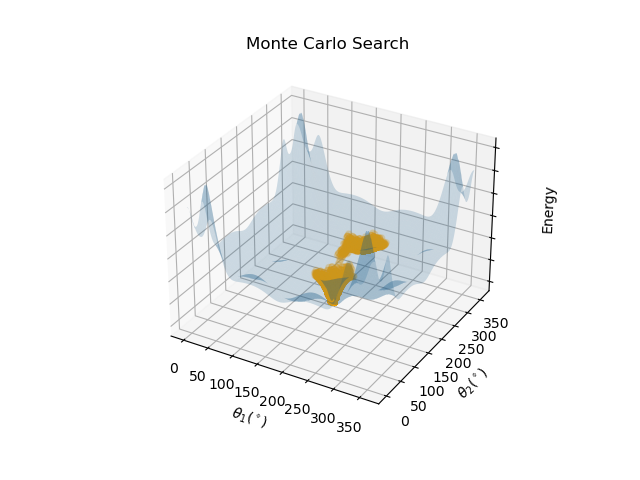

In [173]:
# Set the conformation search parameters
niter = 10000
step = np.pi/180.0*4.0
T = 300
# Some constants. Notice that the force field energy is given by kcal/mol, so it needs to be converted.
k = 1.380658e-23
kcal_to_j = 4184.0
Na = 6.02214076e23 

# set random number seed
np.random.seed(0)

# Set initial torsions to some random values
initial_theta1 = np.random.uniform(0, 2*np.pi)
initial_theta2 = np.random.uniform(0, 2*np.pi)
mol.SetTorsion(*torsions[0], initial_theta1)
mol.SetTorsion(*torsions[1], initial_theta2)
print("The initial values: theta1 = %f; theta2 = %f degrees"
      %(initial_theta1*180/np.pi, initial_theta2*180/np.pi,))

# Set up the force field and compute the initial energy
ff = ob.OBForceField_FindType("MMFF94")
ff.Setup(mol)
previous_energy = ff.Energy()

# Perform a Monte Carlo conformation search
mc_theta1 = []
mc_theta2 = []
mc_energies = []
for i in range(niter):
    # Implement the Metropolis Monte Carlo procedure
    index = np.random.choice([0, 1])
    previous_torsion = mol.GetTorsion(*torsions[index])/180.0*np.pi
    sign = np.random.choice([-1, 1])
    new_torsion = previous_torsion + sign * step
    mol.SetTorsion(*torsions[index], new_torsion)
    # Calculate the energy of the new structure
    ff.Setup(mol)
    current_energy = ff.Energy()   
    if (current_energy < previous_energy) or (np.exp(-(current_energy - previous_energy)*(kcal_to_j/Na)/(k * T)) > np.random.rand()):
        mc_theta1.append(mol.GetTorsion(*torsions[0]))
        mc_theta2.append(mol.GetTorsion(*torsions[1]))
        mc_energies.append(current_energy)
        previous_energy = current_energy
    else:
        mol.SetTorsion(*torsions[index], previous_torsion)

mc_energies -= min_energy

# Make sure the dihedral angles are between 0 and 360 degrees
mc_theta1 = np.array(mc_theta1)
mc_theta2 = np.array(mc_theta2)
mc_theta1 = (mc_theta1+360)%360
mc_theta2 = (mc_theta2+360)%360

# Plot the results of the Monte Carlo search
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(theta1*180.0/np.pi, theta2*180.0/np.pi, np.log10(energies + 0.1), alpha=0.2) # Avoid zero for log scale
ax.set_zticklabels([])
ax.scatter(mc_theta1, mc_theta2, np.log10(mc_energies + 0.1), color="orange", alpha=0.2)
ax.set_xlabel(r'$\theta_1 (^\circ)$')
ax.set_ylabel(r'$\theta_2 (^\circ)$')
ax.set_zlabel('Energy')
plt.title("Monte Carlo Search")
plt.show()

**Comment on the observed differences in the conformational sampling of the random and the Monte Carlo procedures.**

Write your comments: This search is more concentrated and have a purpose sort to speak

**Explore the effect of the temperature on the acceptance and rejection of the moves.**

Write your comments: Higher temperature yields wider sampling area

## Part II: Conformation Search for Aminoalcohols
Aminoalcohols are potentially capable of forming intramolecular hydrogen bonding interactions. Below, we show the structure for a simple aminoalcohol. Given what you learned from the above exercises, perform a conformation search on the given aminoalcohol and confirm that it can indeed form an intramolecular hydrogen bond. For the conformational search, use the following two dihedral angles: O-C-C-N, and C-C-N-H, choosing one of the amino hydrogens. First, perform a systematic search and construct a three-dimensional potential energy surface. Then, explore the use of the random search and Monte Carlo search algorithms for identifying low energy conformers of the aminoalcohol. Write detailed comments on all your steps.

In [205]:
import numpy as np
from openbabel import openbabel as ob
import nglview as nv
mol = ob.OBMol()
def to_pdb(infile,outfile):
    conv = ob.OBConversion()
    conv.SetInAndOutFormats("xyz","pdb")
    conv.ReadFile(mol, infile)
    conv.WriteFile(mol, outfile)
to_pdb("aminoalcohol.xyz","gga.pdb")
view = nv.show_structure_file("gga.pdb")
view.add_representation('label', labelType='serial', backgroundColor='black', showBackground=True)
view

NGLWidget()

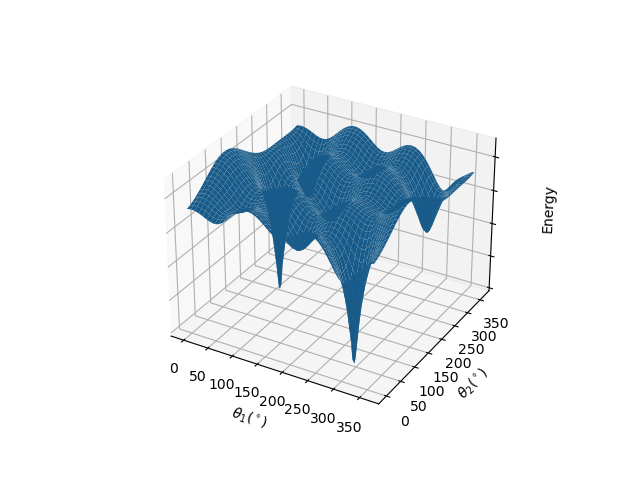

In [206]:
# Perform the conformation searches
torsionss = [[3, 2, 1, 7], [2, 1, 7, 8]]
theta1 = np.linspace(0, 2*np.pi, 361)
theta2 = np.linspace(0, 2*np.pi, 361)

theta1, theta2 = np.meshgrid(theta1, theta2)
energies = np.zeros_like(theta1)

# Calculate the energy on the grid
ff = ob.OBForceField_FindType("MMFF94")
for i in range(len(theta1)):
    for j in range(len(theta2)):
        mol.SetTorsion(*torsionss[0], theta1[i, j])
        mol.SetTorsion(*torsionss[1], theta2[i, j])
        ff.Setup(mol)
        energies[i, j] = ff.Energy()
min_energy = np.min(energies)
energies -= min_energy

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(theta1*180.0/np.pi, theta2*180.0/np.pi, np.log10(energies + 0.1)) # Avoid zero for log scale
ax.set_zticklabels([])
ax.set_xlabel(r'$\theta_1 (^\circ)$')
ax.set_ylabel(r'$\theta_2 (^\circ)$')
ax.set_zlabel('Energy')
plt.show()

The initial values: theta1 = 197.572861; theta2 = 257.468172 degrees


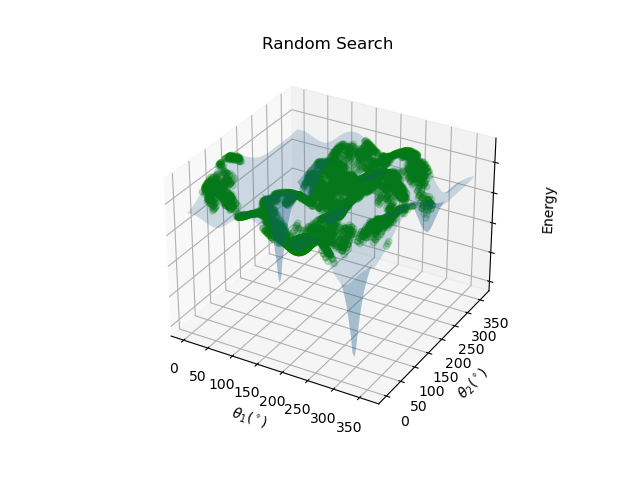

In [208]:
# Set the conformation search parameters
niter = 10000
step = np.pi/180.0*4.0

# set random number seed
np.random.seed(0)

# Set initial torsions to some random values
initial_theta1 = np.random.uniform(0, 2*np.pi)
initial_theta2 = np.random.uniform(0, 2*np.pi)
mol.SetTorsion(*torsionss[0], initial_theta1)
mol.SetTorsion(*torsionss[1], initial_theta2)
print("The initial values: theta1 = %f; theta2 = %f degrees"
      %(initial_theta1*180/np.pi, initial_theta2*180/np.pi,))

# Set up the force field
ff = ob.OBForceField_FindType("MMFF94")

# Perform a random conformation search
random_theta1 = []
random_theta2 = []
random_energies = []

for i in range(niter):
    # Select a dihedral angle randomly
    index = np.random.choice([0, 1])
    # Get the current value for the dihedral angle
    previous_torsion = mol.GetTorsion(*torsionss[index])/180.0*np.pi
    # Randomly choose whether to increase or decrease the dihedral angle and update the angle
    sign = np.random.choice([-1, 1])
    new_torsion = previous_torsion + sign * step
    mol.SetTorsion(*torsionss[index], new_torsion)
    
    # Calculate the energy of the new structure
    ff.Setup(mol)
    current_energy = ff.Energy()

    # Accept all moves
    random_theta1.append(mol.GetTorsion(*torsionss[0]))
    random_theta2.append(mol.GetTorsion(*torsionss[1]))
    random_energies.append(current_energy)

        
random_energies -= min_energy

# Make sure the dihedral angles are between 0 and 360 degrees
random_theta1 = np.array(random_theta1)
random_theta2 = np.array(random_theta2)
random_theta1 = (random_theta1+360)%360
random_theta2 = (random_theta2+360)%360

# Plot the results of the random search
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(theta1*180.0/np.pi, theta2*180.0/np.pi, np.log10(energies + 0.1), alpha=0.2) # Avoid zero for log scale
ax.set_zticklabels([])
ax.scatter(random_theta1, random_theta2, np.log10(random_energies + 0.1), color="green", alpha=0.2)
ax.set_xlabel(r'$\theta_1 (^\circ)$')
ax.set_ylabel(r'$\theta_2 (^\circ)$')
ax.set_zlabel('Energy')
plt.title("Random Search")
plt.show()

The initial values: theta1 = 117.754678; theta2 = 124.609939 degrees


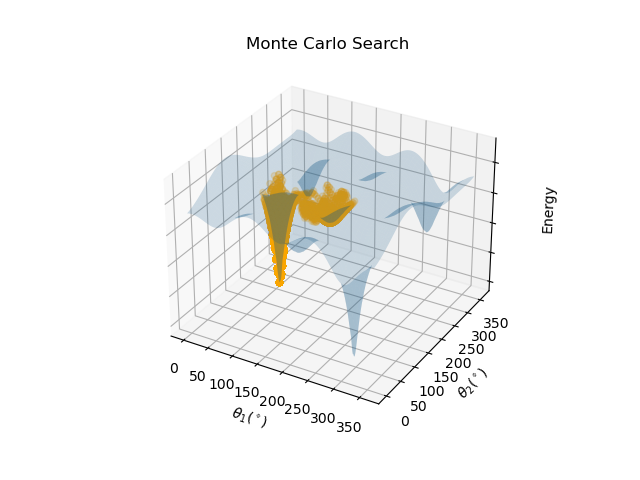

In [210]:
# Set the conformation search parameters
niter = 10000
step = np.pi/180.0*4.0
T = 300
# Some constants. Notice that the force field energy is given by kcal/mol, so it needs to be converted.
k = 1.380658e-23
kcal_to_j = 4184.0
Na = 6.02214076e23 

# set random number seed
np.random.seed(232)

# Set initial torsions to some random values
initial_theta1 = np.random.uniform(0, 2*np.pi)
initial_theta2 = np.random.uniform(0, 2*np.pi)
mol.SetTorsion(*torsionss[0], initial_theta1)
mol.SetTorsion(*torsionss[1], initial_theta2)
print("The initial values: theta1 = %f; theta2 = %f degrees"
      %(initial_theta1*180/np.pi, initial_theta2*180/np.pi,))

# Set up the force field and compute the initial energy
ff = ob.OBForceField_FindType("MMFF94")
ff.Setup(mol)
previous_energy = ff.Energy()

# Perform a Monte Carlo conformation search
mc_theta1 = []
mc_theta2 = []
mc_energies = []
for i in range(niter):
    # Implement the Metropolis Monte Carlo procedure
    index = np.random.choice([0, 1])
    previous_torsion = mol.GetTorsion(*torsionss[index])/180.0*np.pi
    sign = np.random.choice([-1, 1])
    new_torsion = previous_torsion + sign * step
    mol.SetTorsion(*torsionss[index], new_torsion)
    # Calculate the energy of the new structure
    ff.Setup(mol)
    current_energy = ff.Energy()   
    if (current_energy < previous_energy) or (np.exp(-(current_energy - previous_energy)*(kcal_to_j/Na)/(k * T)) > np.random.rand()):
        mc_theta1.append(mol.GetTorsion(*torsionss[0]))
        mc_theta2.append(mol.GetTorsion(*torsionss[1]))
        mc_energies.append(current_energy)
        previous_energy = current_energy
    else:
        mol.SetTorsion(*torsionss[index], previous_torsion)

mc_energies -= min_energy

# Make sure the dihedral angles are between 0 and 360 degrees
mc_theta1 = np.array(mc_theta1)
mc_theta2 = np.array(mc_theta2)
mc_theta1 = (mc_theta1+360)%360
mc_theta2 = (mc_theta2+360)%360

# Plot the results of the Monte Carlo search
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(theta1*180.0/np.pi, theta2*180.0/np.pi, np.log10(energies + 0.1), alpha=0.2) # Avoid zero for log scale
ax.set_zticklabels([])
ax.scatter(mc_theta1, mc_theta2, np.log10(mc_energies + 0.1), color="orange", alpha=0.2)
ax.set_xlabel(r'$\theta_1 (^\circ)$')
ax.set_ylabel(r'$\theta_2 (^\circ)$')
ax.set_zlabel('Energy')
plt.title("Monte Carlo Search")
plt.show()

**What can you conclude from your conformation searches? Comment on whether the above aminoalcohol can indeed form an intramolecular hydrogen bond.**

Write your comments: 
- Systematic search is good but very expensive. 
- We can see multiple local minimum, but there is two sharp minima, one corresponds to the global minima and one is local. These two strong minima were caused by the hydrogen bond. 
- Monte carlo search is amazing but it can stuck in a local minima. I changed he seed to be able to detect the steep minima.

## Summary
Summarize what you learned in a few points:
- Point 1: Random search can be useless and may fail to detect huge local and global minima
- Point 2: Having a seed is great for debugging, I was stuck on some point and if the seed were changing I would never solve it
- Point 3: I cannot express how fascinated I am by monte carlo, it took me quite sometime to implement it but the results were astonishing. Very useful algorithm 